In [1]:
# Install required packages
! pip install tensorflow Pillow piexif numpy matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   ----- ---------------------------------- 1.0/7.8 MB 5.0 MB/s eta 0:00:02
   ------------ --------------------------- 2.4/7.8 MB 6.1 MB/s eta 0:00:01
   -------------- ------------------------- 2.9/7.8 MB 6.2 MB/s eta 0:00:01
   ------------------------- -------------- 5.0/7.8 MB 5.8 MB/s eta 0:00:01
   -------------------------------- ------- 6.3/7.8 MB 5.9 MB/s eta 0:00:01
   ------------------------------------- -- 7.3/7.8 MB 5.6 MB/s eta 0:00:01
   ---------------------------------------- 7.8/7.8 MB 5.6 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ------------------- -------------------- 1.0/2.2 MB 5.6 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 5.9 MB/s eta 0:00:00


In [2]:
import os
import sys
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
from PIL.ExifTags import TAGS
import piexif
import logging
from datetime import datetime
import shutil
import matplotlib.pyplot as plt

In [4]:
# Configure test directory - MODIFY THIS PATH FOR YOUR TEST FOLDER
TEST_DIR = Path(r"test_images")
BACKUP_DIR = TEST_DIR / 'backup'

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler()
    ]
)

# Create backup directory if it doesn't exist
BACKUP_DIR.mkdir(parents=True, exist_ok=True)

In [22]:
class SafariImageProcessor:
    def __init__(self, source_dir, backup_dir=None):
        """
        Initialize the image processor with source directory and optional backup directory
        """
        self.source_dir = Path(source_dir)
        self.backup_dir = Path(backup_dir) if backup_dir else Path(source_dir) / 'backup'
        self.model = None
        self.processed_count = 0
        
        # Create backup directory if it doesn't exist
        self.backup_dir.mkdir(parents=True, exist_ok=True)
        
        # Initialize the ML model
        self._load_model()
        
        # Supported image extensions
        self.supported_extensions = {'.jpg', '.jpeg', '.png'}

    def _load_model(self):
        """Load multiple models for better accuracy"""
        try:
            # Load multiple models with their specific input sizes
            self.models = {
                'resnet': {
                    'model': tf.keras.applications.ResNet50V2(weights='imagenet'),
                    'size': (224, 224)
                },
                'efficient': {
                    'model': tf.keras.applications.EfficientNetB4(weights='imagenet'),
                    'size': (380, 380)
                },
                'dense': {
                    'model': tf.keras.applications.DenseNet201(weights='imagenet'),
                    'size': (224, 224)
                }
            }
            self.preprocess_input = {
                'resnet': tf.keras.applications.resnet_v2.preprocess_input,
                'efficient': tf.keras.applications.efficientnet.preprocess_input,
                'dense': tf.keras.applications.densenet.preprocess_input
            }
            logging.info("Successfully loaded ensemble models")
        except Exception as e:
            logging.error(f"Failed to load ML models: {str(e)}")
            raise

    def _predict_animal(self, img_path):
        """
        Predict animal using ensemble of models with improved accuracy
        """
        try:
            def preprocess_image(img_path, size):
                img = image.load_img(img_path, target_size=size)
                x = image.img_to_array(img)
                
                # Create augmented versions
                augmented = []
                # Original
                augmented.append(x)
                # Flipped
                flipped = tf.image.flip_left_right(x)
                augmented.append(flipped.numpy())
                # Brightened
                brightened = tf.image.adjust_brightness(x, delta=0.2)
                augmented.append(brightened.numpy())
                # Contrasted
                contrasted = tf.image.adjust_contrast(x, contrast_factor=1.2)
                augmented.append(contrasted.numpy())
                
                return np.stack(augmented)

            predictions_combined = []
            
            # Process with each model in ensemble
            for model_name, model_info in self.models.items():
                model = model_info['model']
                size = model_info['size']
                preprocess = self.preprocess_input[model_name]
                
                # Get preprocessed images
                images = preprocess_image(img_path, size)
                x = preprocess(images)
                
                # Make predictions
                preds = model.predict(x, verbose=0)
                
                # Process predictions
                for pred in preds:
                    predictions = decode_predictions(np.expand_dims(pred, 0), top=10)[0]
                    predictions_combined.extend(predictions)

            # Enhanced category mapping
            category_mapping = {
                'ostrich': ['ostrich', 'common_ostrich', 'African_ostrich'],
                'bird': ['bird', 'crane', 'peacock', 'hornbill', 'vulture', 'eagle', 'bustard', 'stork'],
                'elephant': ['elephant', 'African_elephant', 'Indian_elephant', 'tusker'],
                'monkey': ['monkey', 'macaque', 'baboon', 'chimpanzee', 'gorilla', 'orangutan', 'langur', 'colobus'],
                'giraffe': ['giraffe', 'reticulated_giraffe'],
                'zebra': ['zebra', 'plains_zebra', 'Grevy_zebra'],
                'lion': ['lion', 'male_lion', 'lioness', 'African_lion'],
                'lion_cub': ['lion_cub', 'cub', 'young_lion', 'cat_baby'],
                'leopard': ['leopard', 'spotted_leopard'],
                'cheetah': ['cheetah', 'spotted_cat', 'running_cat'],
                'buffalo': ['buffalo', 'African_buffalo', 'water_buffalo', 'cape_buffalo'],
                'antelope': ['antelope', 'gazelle', 'impala', 'kudu', 'springbok', 'gemsbok', 'oryx'],
                'wildebeest': ['wildebeest', 'gnu', 'blue_wildebeest'],
                'hippopotamus': ['hippopotamus', 'hippo', 'river_horse'],
                'crocodile': ['crocodile', 'Nile_crocodile', 'alligator'],
                'hyena': ['hyena', 'spotted_hyena', 'striped_hyena']
            }

            # Log raw predictions
            logging.debug(f"\nRaw predictions for {img_path}:")
            for pred in predictions_combined:
                logging.debug(f"{pred[1]}: {pred[2]:.3f}")

            # Aggregate predictions
            pred_scores = {}
            for _, label, conf in predictions_combined:
                for category, similar_labels in category_mapping.items():
                    if any(similar in label.lower() for similar in similar_labels):
                        if category not in pred_scores:
                            pred_scores[category] = []
                        pred_scores[category].append(conf)

            # Calculate final scores
            final_predictions = {}
            for category, scores in pred_scores.items():
                top_scores = sorted(scores, reverse=True)[:3]
                if top_scores:  # Only include if we have scores
                    final_predictions[category] = np.mean(top_scores)

            # Get best prediction
            if final_predictions:
                best_category = max(final_predictions.items(), key=lambda x: x[1])
                return best_category[0], float(best_category[1])

            return None, 0.0

        except Exception as e:
            logging.error(f"Error predicting image {img_path}: {str(e)}")
            return None, 0.0

    def _get_animal_categories(self):
        """Return set of ImageNet categories that represent animals we're interested in"""
        return {
            'lion', 'lion_cub', 'elephant', 'zebra', 'giraffe', 'leopard', 'cheetah',
            'hippopotamus', 'antelope', 'buffalo', 'wildebeest', 
            'monkey', 'crocodile','ostrich', 'bird', 'penguin', 'eagle'
        }

    def preview_image_prediction(self, img_path):
        """Preview image with detailed prediction information"""
        img = Image.open(img_path)
        animal_name, confidence = self._predict_animal(img_path)
        
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Display image
        ax1.imshow(img)
        ax1.axis('off')
        ax1.set_title(f'Original Image: {Path(img_path).name}')
        
        # Display prediction info
        ax2.axis('off')
        prediction_text = f"""
        Predicted Animal: {animal_name}
        Confidence: {confidence:.3f}
        
        Threshold: {0.35:.2f}
        Status: {'✓ Accepted' if confidence > 0.35 else '✗ Rejected'}
        
        Note: Check logs for detailed predictions
        """
        ax2.text(0.1, 0.5, prediction_text, fontsize=12, va='center')
        
        plt.show()
        
        return animal_name, confidence

    # Add a testing function that shows more detail
    def test_single_image(image_path):
        print(f"\nTesting image: {image_path}")
        
        # Enable debug logging temporarily
        logging.getLogger().setLevel(logging.DEBUG)
        
        animal, confidence = processor.preview_image_prediction(image_path)
        
        # Reset logging level
        logging.getLogger().setLevel(logging.INFO)
        
        print(f"\nFinal Results:")
        print(f"Animal: {animal}")
        print(f"Confidence: {confidence:.3f}")
        print(f"Status: {'Accepted' if confidence > 0.35 else 'Rejected'}")
        return animal, confidence

    def _add_metadata_tags(self, img_path, animal_name, confidence):
        """Add metadata tags to the image using piexif"""
        try:
            # Load existing EXIF data
            exif_dict = piexif.load(str(img_path))
            
            # Create new EXIF UserComment
            comment = f"Animal: {animal_name}; Confidence: {confidence:.2f}"
            user_comment = piexif.helper.UserComment.create(comment)
            
            # Add to EXIF
            if "Exif" not in exif_dict:
                exif_dict["Exif"] = {}
            exif_dict["Exif"][piexif.ExifIFD.UserComment] = user_comment
            
            # Save EXIF data back to image
            exif_bytes = piexif.dump(exif_dict)
            piexif.insert(exif_bytes, str(img_path))
            
            logging.info(f"Added metadata tags to {img_path}")
            
        except Exception as e:
            logging.warning(f"Failed to add metadata to {img_path}: {str(e)}")

    def _backup_image(self, img_path):
        """Create a backup of the original image"""
        try:
            backup_path = self.backup_dir / img_path.name
            shutil.copy2(img_path, backup_path)
            logging.info(f"Created backup of {img_path.name}")
            return True
        except Exception as e:
            logging.error(f"Failed to create backup of {img_path}: {str(e)}")
            return False

    def _generate_new_filename(self, original_path, animal_name):
        """Generate new filename with animal name and sequence number"""
        self.processed_count += 1
        timestamp = datetime.now().strftime("%Y%m%d")
        sequence = f"{self.processed_count:04d}"
        extension = original_path.suffix.lower()
        
        new_name = f"{animal_name}_{timestamp}_{sequence}{extension}"
        return original_path.parent / new_name

    def process_single_image(self, img_path):
        """Process a single image with improved confidence handling"""
        img_path = Path(img_path)
        results = {
            'original_name': img_path.name,
            'success': False,
            'new_name': None,
            'animal': None,
            'confidence': None,
            'error': None
        }
        
        try:
            if not self._backup_image(img_path):
                results['error'] = "Backup failed"
                return results
            
            animal_name, confidence = self._predict_animal(img_path)
            results['animal'] = animal_name
            results['confidence'] = confidence
            
            # Adjusted confidence threshold based on category
            thresholds = {
                'lion_cub': 0.3,  # Lower threshold for cubs as they're harder to detect
                'bird': 0.4,      # Lower for general categories
                'default': 0.35   # Default threshold
            }
            
            category_threshold = thresholds.get(animal_name, thresholds['default'])
            
            if animal_name and confidence > category_threshold:
                new_path = self._generate_new_filename(img_path, animal_name)
                self._add_metadata_tags(img_path, animal_name, confidence)
                img_path.rename(new_path)
                results['new_name'] = new_path.name
                results['success'] = True
            else:
                results['error'] = "Low confidence prediction"
                
        except Exception as e:
            results['error'] = str(e)
            
        return results

    def process_images(self):
        """Process all images in the source directory"""
        image_files = [
            f for f in self.source_dir.glob("*")
            if f.suffix.lower() in self.supported_extensions
        ]
        
        results = []
        for img_path in image_files:
            result = self.process_single_image(img_path)
            results.append(result)
            
        return results

2024-10-27 13:40:38,429 - INFO - Successfully loaded ensemble models
2024-10-27 13:40:38,432 - DEBUG - tag: Make (271) - type: string (2) Tag Location: 22 - Data Location: 172 - value: b'NIKON CORPORATION\x00'
2024-10-27 13:40:38,433 - DEBUG - tag: Model (272) - type: string (2) Tag Location: 34 - Data Location: 192 - value: b'NIKON D3500\x00'
2024-10-27 13:40:38,433 - DEBUG - tag: Orientation (274) - type: short (3) - value: b'\x01\x00'
2024-10-27 13:40:38,435 - DEBUG - tag: XResolution (282) - type: rational (5) Tag Location: 58 - Data Location: 204 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:40:38,437 - DEBUG - tag: YResolution (283) - type: rational (5) Tag Location: 70 - Data Location: 212 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:40:38,438 - DEBUG - tag: ResolutionUnit (296) - type: short (3) - value: b'\x02\x00'
2024-10-27 13:40:38,438 - DEBUG - tag: Software (305) - type: string (2) Tag Location: 94 - Data Location: 220 - value: b'Ver.1.00 \x00'
2024-1


Testing image: 20240418_114116.jpg


2024-10-27 13:40:41,401 - DEBUG - tag: Make (271) - type: string (2) Tag Location: 22 - Data Location: 172 - value: b'NIKON CORPORATION\x00'
2024-10-27 13:40:41,402 - DEBUG - tag: Model (272) - type: string (2) Tag Location: 34 - Data Location: 192 - value: b'NIKON D3500\x00'
2024-10-27 13:40:41,403 - DEBUG - tag: Orientation (274) - type: short (3) - value: b'\x01\x00'
2024-10-27 13:40:41,404 - DEBUG - tag: XResolution (282) - type: rational (5) Tag Location: 58 - Data Location: 204 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:40:41,405 - DEBUG - tag: YResolution (283) - type: rational (5) Tag Location: 70 - Data Location: 212 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:40:41,406 - DEBUG - tag: ResolutionUnit (296) - type: short (3) - value: b'\x02\x00'
2024-10-27 13:40:41,406 - DEBUG - tag: Software (305) - type: string (2) Tag Location: 94 - Data Location: 220 - value: b'Ver.1.00 \x00'
2024-10-27 13:40:41,407 - DEBUG - tag: DateTime (306) - type: string (2) Ta

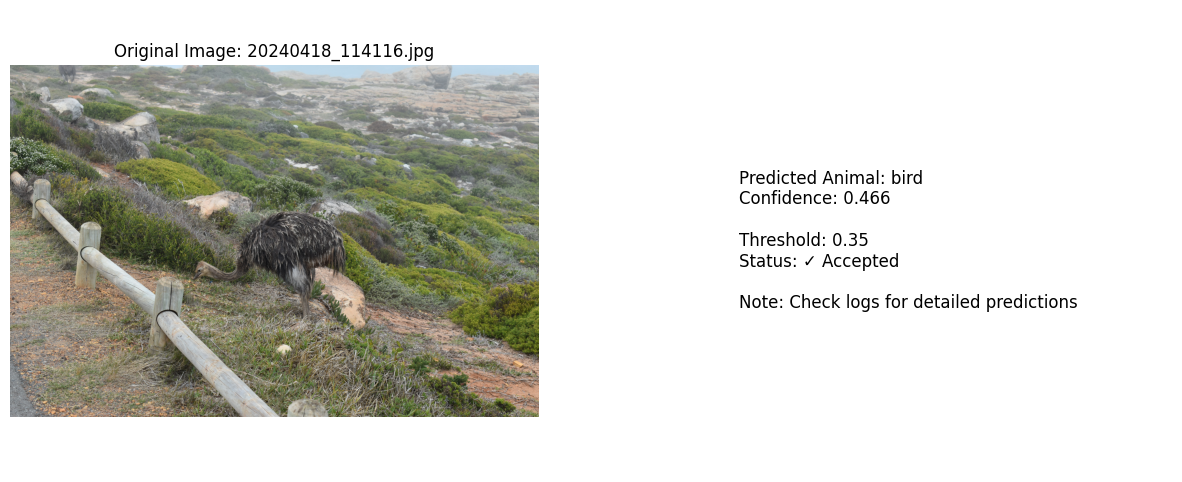

2024-10-27 13:40:58,698 - DEBUG - tag: Make (271) - type: string (2) Tag Location: 22 - Data Location: 172 - value: b'NIKON CORPORATION\x00'
2024-10-27 13:40:58,699 - DEBUG - tag: Model (272) - type: string (2) Tag Location: 34 - Data Location: 192 - value: b'NIKON D3500\x00'
2024-10-27 13:40:58,700 - DEBUG - tag: Orientation (274) - type: short (3) - value: b'\x01\x00'
2024-10-27 13:40:58,701 - DEBUG - tag: XResolution (282) - type: rational (5) Tag Location: 58 - Data Location: 204 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:40:58,701 - DEBUG - tag: YResolution (283) - type: rational (5) Tag Location: 70 - Data Location: 212 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:40:58,702 - DEBUG - tag: ResolutionUnit (296) - type: short (3) - value: b'\x02\x00'
2024-10-27 13:40:58,703 - DEBUG - tag: Software (305) - type: string (2) Tag Location: 94 - Data Location: 220 - value: b'Ver.1.00 \x00'
2024-10-27 13:40:58,704 - DEBUG - tag: DateTime (306) - type: string (2) Ta


Results:
Animal: bird
Confidence: 0.466
Status: ✓ Accepted

Testing image: 20241027_0001.jpg


2024-10-27 13:40:59,387 - DEBUG - tag: Make (271) - type: string (2) Tag Location: 22 - Data Location: 172 - value: b'NIKON CORPORATION\x00'
2024-10-27 13:40:59,388 - DEBUG - tag: Model (272) - type: string (2) Tag Location: 34 - Data Location: 192 - value: b'NIKON D3500\x00'
2024-10-27 13:40:59,388 - DEBUG - tag: Orientation (274) - type: short (3) - value: b'\x01\x00'
2024-10-27 13:40:59,389 - DEBUG - tag: XResolution (282) - type: rational (5) Tag Location: 58 - Data Location: 204 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:40:59,389 - DEBUG - tag: YResolution (283) - type: rational (5) Tag Location: 70 - Data Location: 212 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:40:59,390 - DEBUG - tag: ResolutionUnit (296) - type: short (3) - value: b'\x02\x00'
2024-10-27 13:40:59,390 - DEBUG - tag: Software (305) - type: string (2) Tag Location: 94 - Data Location: 220 - value: b'Ver.1.00 \x00'
2024-10-27 13:40:59,390 - DEBUG - tag: DateTime (306) - type: string (2) Ta

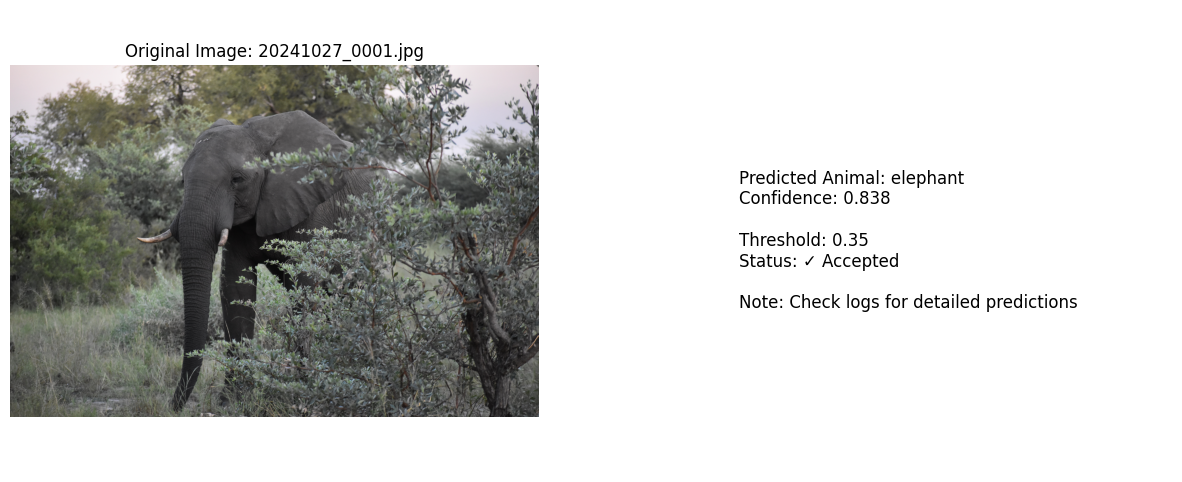

2024-10-27 13:41:04,597 - DEBUG - tag: Make (271) - type: string (2) Tag Location: 22 - Data Location: 172 - value: b'NIKON CORPORATION\x00'
2024-10-27 13:41:04,598 - DEBUG - tag: Model (272) - type: string (2) Tag Location: 34 - Data Location: 192 - value: b'NIKON D3500\x00'
2024-10-27 13:41:04,598 - DEBUG - tag: Orientation (274) - type: short (3) - value: b'\x01\x00'
2024-10-27 13:41:04,599 - DEBUG - tag: XResolution (282) - type: rational (5) Tag Location: 58 - Data Location: 204 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:04,600 - DEBUG - tag: YResolution (283) - type: rational (5) Tag Location: 70 - Data Location: 212 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:04,604 - DEBUG - tag: ResolutionUnit (296) - type: short (3) - value: b'\x02\x00'
2024-10-27 13:41:04,605 - DEBUG - tag: Software (305) - type: string (2) Tag Location: 94 - Data Location: 220 - value: b'Ver.1.00 \x00'
2024-10-27 13:41:04,605 - DEBUG - tag: DateTime (306) - type: string (2) Ta


Results:
Animal: elephant
Confidence: 0.838
Status: ✓ Accepted

Testing 10 images:

Image 1/10: 20240418_114116.jpg


2024-10-27 13:41:05,505 - DEBUG - tag: Make (271) - type: string (2) Tag Location: 22 - Data Location: 172 - value: b'NIKON CORPORATION\x00'
2024-10-27 13:41:05,506 - DEBUG - tag: Model (272) - type: string (2) Tag Location: 34 - Data Location: 192 - value: b'NIKON D3500\x00'
2024-10-27 13:41:05,507 - DEBUG - tag: Orientation (274) - type: short (3) - value: b'\x01\x00'
2024-10-27 13:41:05,508 - DEBUG - tag: XResolution (282) - type: rational (5) Tag Location: 58 - Data Location: 204 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:05,509 - DEBUG - tag: YResolution (283) - type: rational (5) Tag Location: 70 - Data Location: 212 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:05,510 - DEBUG - tag: ResolutionUnit (296) - type: short (3) - value: b'\x02\x00'
2024-10-27 13:41:05,510 - DEBUG - tag: Software (305) - type: string (2) Tag Location: 94 - Data Location: 220 - value: b'Ver.1.00 \x00'
2024-10-27 13:41:05,511 - DEBUG - tag: DateTime (306) - type: string (2) Ta

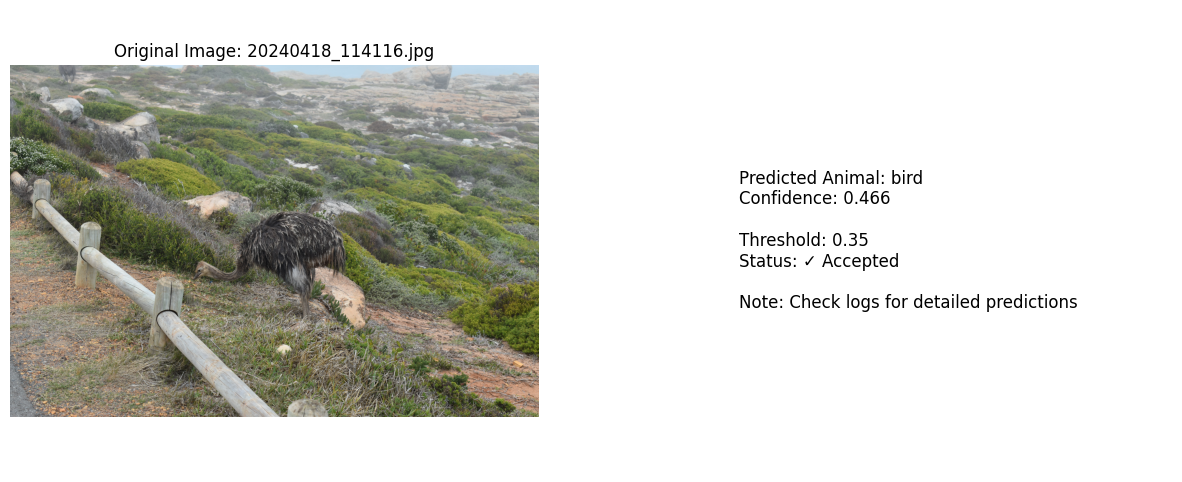

2024-10-27 13:41:10,145 - DEBUG - tag: Make (271) - type: string (2) Tag Location: 22 - Data Location: 172 - value: b'NIKON CORPORATION\x00'
2024-10-27 13:41:10,146 - DEBUG - tag: Model (272) - type: string (2) Tag Location: 34 - Data Location: 192 - value: b'NIKON D3500\x00'
2024-10-27 13:41:10,146 - DEBUG - tag: Orientation (274) - type: short (3) - value: b'\x01\x00'
2024-10-27 13:41:10,147 - DEBUG - tag: XResolution (282) - type: rational (5) Tag Location: 58 - Data Location: 204 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:10,148 - DEBUG - tag: YResolution (283) - type: rational (5) Tag Location: 70 - Data Location: 212 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:10,149 - DEBUG - tag: ResolutionUnit (296) - type: short (3) - value: b'\x02\x00'
2024-10-27 13:41:10,150 - DEBUG - tag: Software (305) - type: string (2) Tag Location: 94 - Data Location: 220 - value: b'Ver.1.00 \x00'
2024-10-27 13:41:10,151 - DEBUG - tag: DateTime (306) - type: string (2) Ta

Predicted: bird (Confidence: 0.466)

Image 2/10: 20240418_130025_5.jpg


2024-10-27 13:41:10,870 - DEBUG - tag: Make (271) - type: string (2) Tag Location: 22 - Data Location: 172 - value: b'NIKON CORPORATION\x00'
2024-10-27 13:41:10,871 - DEBUG - tag: Model (272) - type: string (2) Tag Location: 34 - Data Location: 192 - value: b'NIKON D3500\x00'
2024-10-27 13:41:10,873 - DEBUG - tag: Orientation (274) - type: short (3) - value: b'\x01\x00'
2024-10-27 13:41:10,873 - DEBUG - tag: XResolution (282) - type: rational (5) Tag Location: 58 - Data Location: 204 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:10,874 - DEBUG - tag: YResolution (283) - type: rational (5) Tag Location: 70 - Data Location: 212 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:10,875 - DEBUG - tag: ResolutionUnit (296) - type: short (3) - value: b'\x02\x00'
2024-10-27 13:41:10,875 - DEBUG - tag: Software (305) - type: string (2) Tag Location: 94 - Data Location: 220 - value: b'Ver.1.00 \x00'
2024-10-27 13:41:10,876 - DEBUG - tag: DateTime (306) - type: string (2) Ta

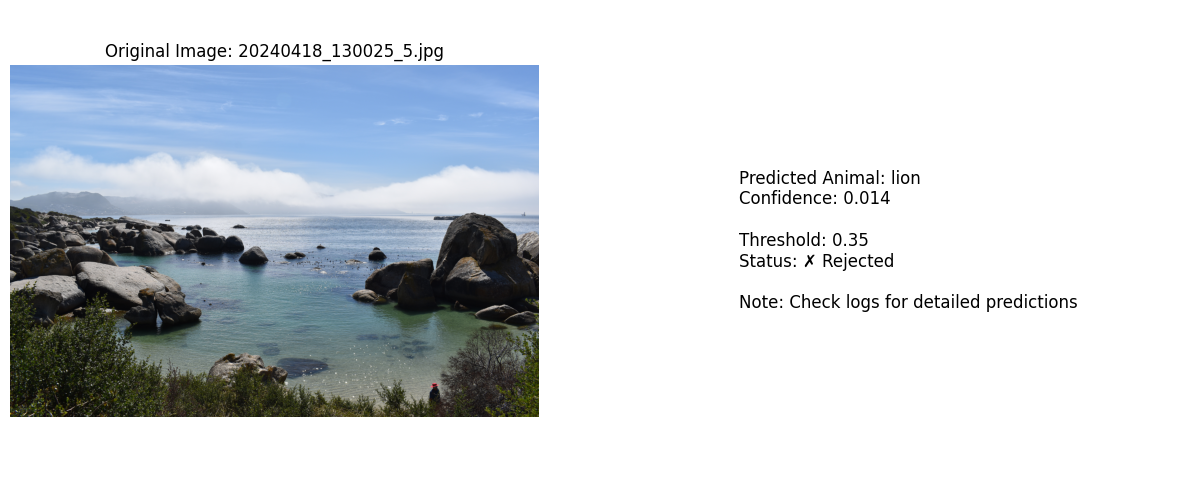

2024-10-27 13:41:15,660 - DEBUG - tag: Make (271) - type: string (2) Tag Location: 22 - Data Location: 172 - value: b'NIKON CORPORATION\x00'
2024-10-27 13:41:15,661 - DEBUG - tag: Model (272) - type: string (2) Tag Location: 34 - Data Location: 192 - value: b'NIKON D3500\x00'
2024-10-27 13:41:15,662 - DEBUG - tag: Orientation (274) - type: short (3) - value: b'\x01\x00'
2024-10-27 13:41:15,664 - DEBUG - tag: XResolution (282) - type: rational (5) Tag Location: 58 - Data Location: 204 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:15,665 - DEBUG - tag: YResolution (283) - type: rational (5) Tag Location: 70 - Data Location: 212 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:15,666 - DEBUG - tag: ResolutionUnit (296) - type: short (3) - value: b'\x02\x00'
2024-10-27 13:41:15,666 - DEBUG - tag: Software (305) - type: string (2) Tag Location: 94 - Data Location: 220 - value: b'Ver.1.00 \x00'
2024-10-27 13:41:15,667 - DEBUG - tag: DateTime (306) - type: string (2) Ta

Predicted: lion (Confidence: 0.014)

Image 3/10: 20240418_133453_2.jpg


2024-10-27 13:41:16,341 - DEBUG - tag: Make (271) - type: string (2) Tag Location: 22 - Data Location: 172 - value: b'NIKON CORPORATION\x00'
2024-10-27 13:41:16,341 - DEBUG - tag: Model (272) - type: string (2) Tag Location: 34 - Data Location: 192 - value: b'NIKON D3500\x00'
2024-10-27 13:41:16,342 - DEBUG - tag: Orientation (274) - type: short (3) - value: b'\x01\x00'
2024-10-27 13:41:16,343 - DEBUG - tag: XResolution (282) - type: rational (5) Tag Location: 58 - Data Location: 204 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:16,343 - DEBUG - tag: YResolution (283) - type: rational (5) Tag Location: 70 - Data Location: 212 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:16,344 - DEBUG - tag: ResolutionUnit (296) - type: short (3) - value: b'\x02\x00'
2024-10-27 13:41:16,344 - DEBUG - tag: Software (305) - type: string (2) Tag Location: 94 - Data Location: 220 - value: b'Ver.1.00 \x00'
2024-10-27 13:41:16,346 - DEBUG - tag: DateTime (306) - type: string (2) Ta

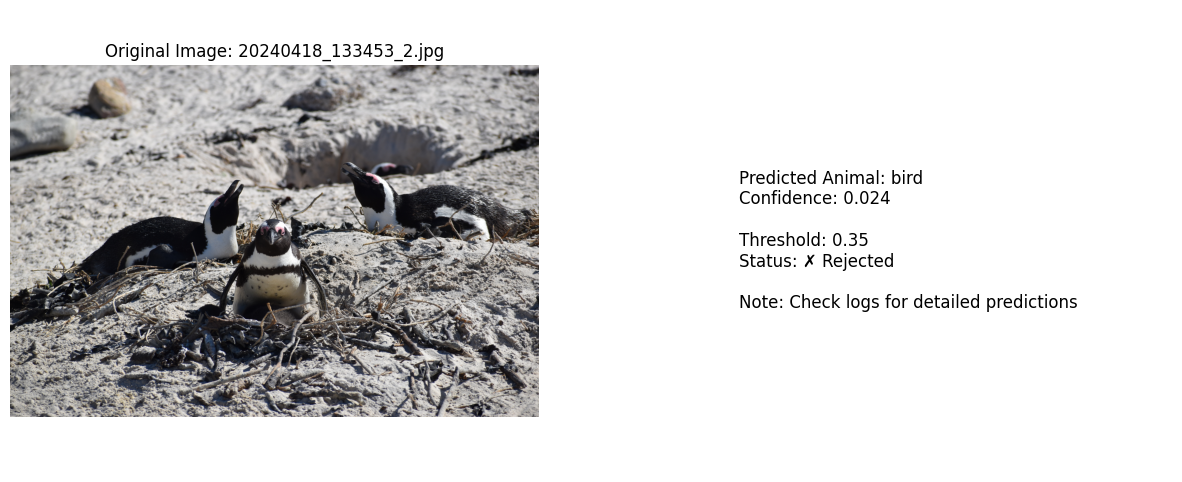

2024-10-27 13:41:21,083 - DEBUG - tag: Make (271) - type: string (2) Tag Location: 22 - Data Location: 172 - value: b'NIKON CORPORATION\x00'
2024-10-27 13:41:21,084 - DEBUG - tag: Model (272) - type: string (2) Tag Location: 34 - Data Location: 192 - value: b'NIKON D3500\x00'
2024-10-27 13:41:21,085 - DEBUG - tag: Orientation (274) - type: short (3) - value: b'\x01\x00'
2024-10-27 13:41:21,087 - DEBUG - tag: XResolution (282) - type: rational (5) Tag Location: 58 - Data Location: 204 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:21,088 - DEBUG - tag: YResolution (283) - type: rational (5) Tag Location: 70 - Data Location: 212 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:21,089 - DEBUG - tag: ResolutionUnit (296) - type: short (3) - value: b'\x02\x00'
2024-10-27 13:41:21,089 - DEBUG - tag: Software (305) - type: string (2) Tag Location: 94 - Data Location: 220 - value: b'Ver.1.00 \x00'
2024-10-27 13:41:21,090 - DEBUG - tag: DateTime (306) - type: string (2) Ta

Predicted: bird (Confidence: 0.024)

Image 4/10: 20240419_173225.jpg


2024-10-27 13:41:21,729 - DEBUG - tag: Make (271) - type: string (2) Tag Location: 22 - Data Location: 172 - value: b'NIKON CORPORATION\x00'
2024-10-27 13:41:21,730 - DEBUG - tag: Model (272) - type: string (2) Tag Location: 34 - Data Location: 192 - value: b'NIKON D3500\x00'
2024-10-27 13:41:21,731 - DEBUG - tag: Orientation (274) - type: short (3) - value: b'\x01\x00'
2024-10-27 13:41:21,731 - DEBUG - tag: XResolution (282) - type: rational (5) Tag Location: 58 - Data Location: 204 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:21,732 - DEBUG - tag: YResolution (283) - type: rational (5) Tag Location: 70 - Data Location: 212 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:21,732 - DEBUG - tag: ResolutionUnit (296) - type: short (3) - value: b'\x02\x00'
2024-10-27 13:41:21,733 - DEBUG - tag: Software (305) - type: string (2) Tag Location: 94 - Data Location: 220 - value: b'Ver.1.00 \x00'
2024-10-27 13:41:21,734 - DEBUG - tag: DateTime (306) - type: string (2) Ta

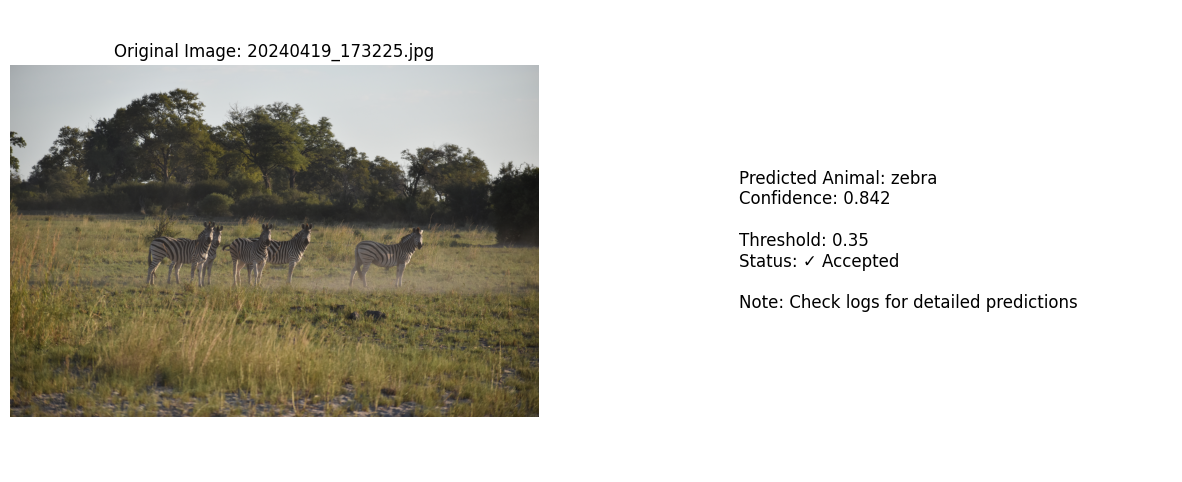

2024-10-27 13:41:26,174 - DEBUG - tag: Make (271) - type: string (2) Tag Location: 22 - Data Location: 172 - value: b'NIKON CORPORATION\x00'
2024-10-27 13:41:26,175 - DEBUG - tag: Model (272) - type: string (2) Tag Location: 34 - Data Location: 192 - value: b'NIKON D3500\x00'
2024-10-27 13:41:26,176 - DEBUG - tag: Orientation (274) - type: short (3) - value: b'\x06\x00'
2024-10-27 13:41:26,176 - DEBUG - tag: XResolution (282) - type: rational (5) Tag Location: 58 - Data Location: 204 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:26,178 - DEBUG - tag: YResolution (283) - type: rational (5) Tag Location: 70 - Data Location: 212 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:26,179 - DEBUG - tag: ResolutionUnit (296) - type: short (3) - value: b'\x02\x00'
2024-10-27 13:41:26,179 - DEBUG - tag: Software (305) - type: string (2) Tag Location: 94 - Data Location: 220 - value: b'Ver.1.00 \x00'
2024-10-27 13:41:26,181 - DEBUG - tag: DateTime (306) - type: string (2) Ta

Predicted: zebra (Confidence: 0.842)

Image 5/10: 20240420_072513.jpg


2024-10-27 13:41:26,976 - DEBUG - tag: Make (271) - type: string (2) Tag Location: 22 - Data Location: 172 - value: b'NIKON CORPORATION\x00'
2024-10-27 13:41:26,977 - DEBUG - tag: Model (272) - type: string (2) Tag Location: 34 - Data Location: 192 - value: b'NIKON D3500\x00'
2024-10-27 13:41:26,978 - DEBUG - tag: Orientation (274) - type: short (3) - value: b'\x06\x00'
2024-10-27 13:41:26,979 - DEBUG - tag: XResolution (282) - type: rational (5) Tag Location: 58 - Data Location: 204 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:26,979 - DEBUG - tag: YResolution (283) - type: rational (5) Tag Location: 70 - Data Location: 212 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:26,980 - DEBUG - tag: ResolutionUnit (296) - type: short (3) - value: b'\x02\x00'
2024-10-27 13:41:26,980 - DEBUG - tag: Software (305) - type: string (2) Tag Location: 94 - Data Location: 220 - value: b'Ver.1.00 \x00'
2024-10-27 13:41:26,981 - DEBUG - tag: DateTime (306) - type: string (2) Ta

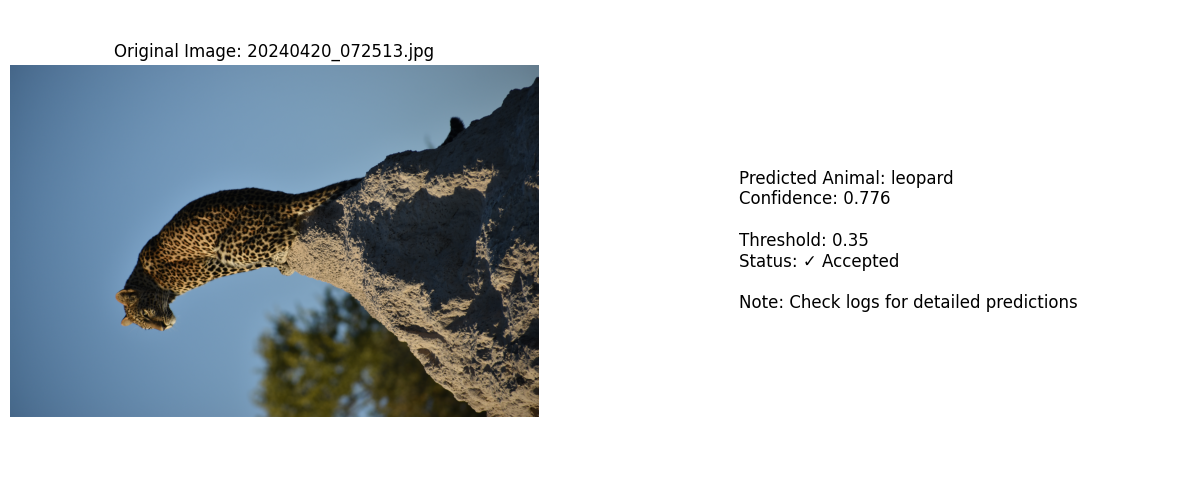

2024-10-27 13:41:32,068 - DEBUG - tag: Make (271) - type: string (2) Tag Location: 22 - Data Location: 172 - value: b'NIKON CORPORATION\x00'
2024-10-27 13:41:32,069 - DEBUG - tag: Model (272) - type: string (2) Tag Location: 34 - Data Location: 192 - value: b'NIKON D3500\x00'
2024-10-27 13:41:32,070 - DEBUG - tag: Orientation (274) - type: short (3) - value: b'\x06\x00'
2024-10-27 13:41:32,070 - DEBUG - tag: XResolution (282) - type: rational (5) Tag Location: 58 - Data Location: 204 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:32,071 - DEBUG - tag: YResolution (283) - type: rational (5) Tag Location: 70 - Data Location: 212 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:32,071 - DEBUG - tag: ResolutionUnit (296) - type: short (3) - value: b'\x02\x00'
2024-10-27 13:41:32,072 - DEBUG - tag: Software (305) - type: string (2) Tag Location: 94 - Data Location: 220 - value: b'Ver.1.00 \x00'
2024-10-27 13:41:32,073 - DEBUG - tag: DateTime (306) - type: string (2) Ta

Predicted: leopard (Confidence: 0.776)

Image 6/10: 20240420_082333.jpg


2024-10-27 13:41:32,897 - DEBUG - tag: Make (271) - type: string (2) Tag Location: 22 - Data Location: 172 - value: b'NIKON CORPORATION\x00'
2024-10-27 13:41:32,898 - DEBUG - tag: Model (272) - type: string (2) Tag Location: 34 - Data Location: 192 - value: b'NIKON D3500\x00'
2024-10-27 13:41:32,899 - DEBUG - tag: Orientation (274) - type: short (3) - value: b'\x06\x00'
2024-10-27 13:41:32,899 - DEBUG - tag: XResolution (282) - type: rational (5) Tag Location: 58 - Data Location: 204 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:32,900 - DEBUG - tag: YResolution (283) - type: rational (5) Tag Location: 70 - Data Location: 212 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:32,901 - DEBUG - tag: ResolutionUnit (296) - type: short (3) - value: b'\x02\x00'
2024-10-27 13:41:32,903 - DEBUG - tag: Software (305) - type: string (2) Tag Location: 94 - Data Location: 220 - value: b'Ver.1.00 \x00'
2024-10-27 13:41:32,904 - DEBUG - tag: DateTime (306) - type: string (2) Ta

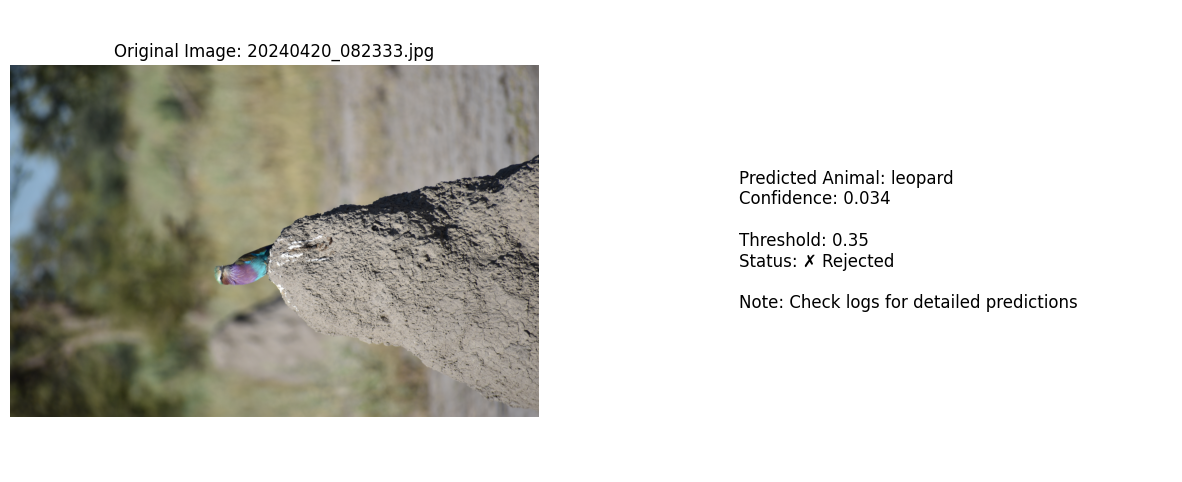

2024-10-27 13:41:37,662 - DEBUG - tag: Make (271) - type: string (2) Tag Location: 22 - Data Location: 172 - value: b'NIKON CORPORATION\x00'
2024-10-27 13:41:37,663 - DEBUG - tag: Model (272) - type: string (2) Tag Location: 34 - Data Location: 192 - value: b'NIKON D3500\x00'
2024-10-27 13:41:37,664 - DEBUG - tag: Orientation (274) - type: short (3) - value: b'\x01\x00'
2024-10-27 13:41:37,665 - DEBUG - tag: XResolution (282) - type: rational (5) Tag Location: 58 - Data Location: 204 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:37,666 - DEBUG - tag: YResolution (283) - type: rational (5) Tag Location: 70 - Data Location: 212 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:37,667 - DEBUG - tag: ResolutionUnit (296) - type: short (3) - value: b'\x02\x00'
2024-10-27 13:41:37,668 - DEBUG - tag: Software (305) - type: string (2) Tag Location: 94 - Data Location: 220 - value: b'Ver.1.00 \x00'
2024-10-27 13:41:37,669 - DEBUG - tag: DateTime (306) - type: string (2) Ta

Predicted: leopard (Confidence: 0.034)

Image 7/10: 20240420_095729.jpg


2024-10-27 13:41:38,364 - DEBUG - tag: Make (271) - type: string (2) Tag Location: 22 - Data Location: 172 - value: b'NIKON CORPORATION\x00'
2024-10-27 13:41:38,365 - DEBUG - tag: Model (272) - type: string (2) Tag Location: 34 - Data Location: 192 - value: b'NIKON D3500\x00'
2024-10-27 13:41:38,365 - DEBUG - tag: Orientation (274) - type: short (3) - value: b'\x01\x00'
2024-10-27 13:41:38,366 - DEBUG - tag: XResolution (282) - type: rational (5) Tag Location: 58 - Data Location: 204 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:38,367 - DEBUG - tag: YResolution (283) - type: rational (5) Tag Location: 70 - Data Location: 212 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:38,368 - DEBUG - tag: ResolutionUnit (296) - type: short (3) - value: b'\x02\x00'
2024-10-27 13:41:38,368 - DEBUG - tag: Software (305) - type: string (2) Tag Location: 94 - Data Location: 220 - value: b'Ver.1.00 \x00'
2024-10-27 13:41:38,370 - DEBUG - tag: DateTime (306) - type: string (2) Ta

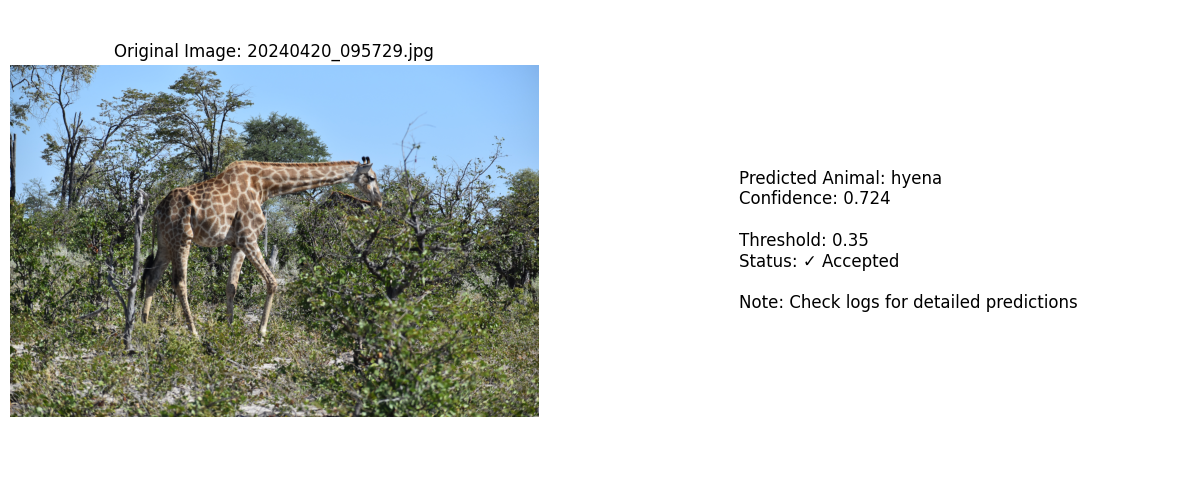

2024-10-27 13:41:43,137 - DEBUG - tag: Make (271) - type: string (2) Tag Location: 22 - Data Location: 172 - value: b'NIKON CORPORATION\x00'
2024-10-27 13:41:43,139 - DEBUG - tag: Model (272) - type: string (2) Tag Location: 34 - Data Location: 192 - value: b'NIKON D3500\x00'
2024-10-27 13:41:43,140 - DEBUG - tag: Orientation (274) - type: short (3) - value: b'\x01\x00'
2024-10-27 13:41:43,141 - DEBUG - tag: XResolution (282) - type: rational (5) Tag Location: 58 - Data Location: 204 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:43,142 - DEBUG - tag: YResolution (283) - type: rational (5) Tag Location: 70 - Data Location: 212 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:43,144 - DEBUG - tag: ResolutionUnit (296) - type: short (3) - value: b'\x02\x00'
2024-10-27 13:41:43,146 - DEBUG - tag: Software (305) - type: string (2) Tag Location: 94 - Data Location: 220 - value: b'Ver.1.00 \x00'
2024-10-27 13:41:43,147 - DEBUG - tag: DateTime (306) - type: string (2) Ta

Predicted: hyena (Confidence: 0.724)

Image 8/10: 20240425_073230.jpg


2024-10-27 13:41:43,923 - DEBUG - tag: Make (271) - type: string (2) Tag Location: 22 - Data Location: 172 - value: b'NIKON CORPORATION\x00'
2024-10-27 13:41:43,924 - DEBUG - tag: Model (272) - type: string (2) Tag Location: 34 - Data Location: 192 - value: b'NIKON D3500\x00'
2024-10-27 13:41:43,925 - DEBUG - tag: Orientation (274) - type: short (3) - value: b'\x01\x00'
2024-10-27 13:41:43,926 - DEBUG - tag: XResolution (282) - type: rational (5) Tag Location: 58 - Data Location: 204 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:43,926 - DEBUG - tag: YResolution (283) - type: rational (5) Tag Location: 70 - Data Location: 212 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:43,927 - DEBUG - tag: ResolutionUnit (296) - type: short (3) - value: b'\x02\x00'
2024-10-27 13:41:43,927 - DEBUG - tag: Software (305) - type: string (2) Tag Location: 94 - Data Location: 220 - value: b'Ver.1.00 \x00'
2024-10-27 13:41:43,927 - DEBUG - tag: DateTime (306) - type: string (2) Ta

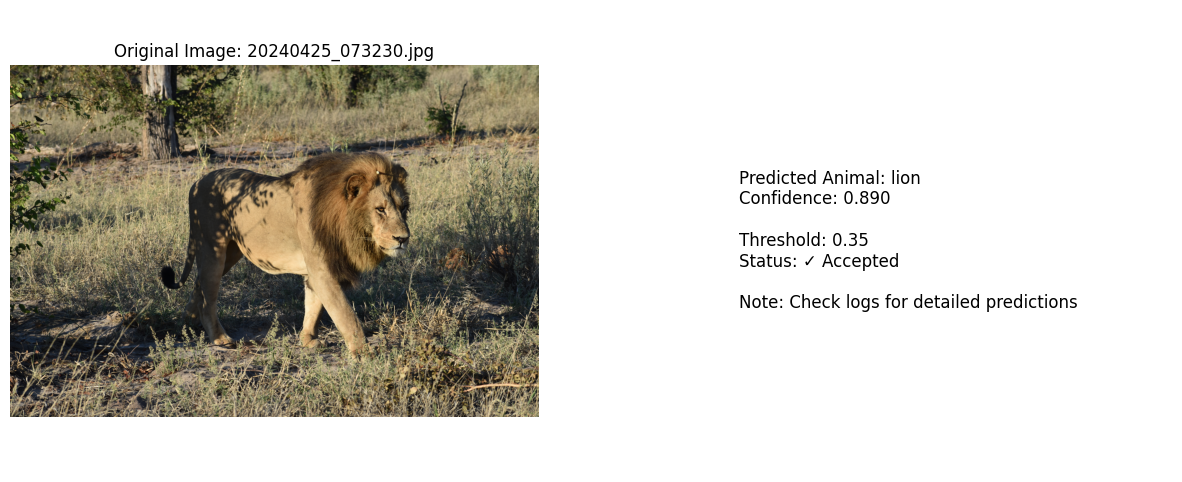

2024-10-27 13:41:48,594 - DEBUG - tag: Make (271) - type: string (2) Tag Location: 22 - Data Location: 172 - value: b'NIKON CORPORATION\x00'
2024-10-27 13:41:48,594 - DEBUG - tag: Model (272) - type: string (2) Tag Location: 34 - Data Location: 192 - value: b'NIKON D3500\x00'
2024-10-27 13:41:48,595 - DEBUG - tag: Orientation (274) - type: short (3) - value: b'\x01\x00'
2024-10-27 13:41:48,596 - DEBUG - tag: XResolution (282) - type: rational (5) Tag Location: 58 - Data Location: 204 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:48,597 - DEBUG - tag: YResolution (283) - type: rational (5) Tag Location: 70 - Data Location: 212 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:48,599 - DEBUG - tag: ResolutionUnit (296) - type: short (3) - value: b'\x02\x00'
2024-10-27 13:41:48,600 - DEBUG - tag: Software (305) - type: string (2) Tag Location: 94 - Data Location: 220 - value: b'Ver.1.00 \x00'
2024-10-27 13:41:48,600 - DEBUG - tag: DateTime (306) - type: string (2) Ta

Predicted: lion (Confidence: 0.890)

Image 9/10: 20240425_075008_1.jpg


2024-10-27 13:41:49,378 - DEBUG - tag: Make (271) - type: string (2) Tag Location: 22 - Data Location: 172 - value: b'NIKON CORPORATION\x00'
2024-10-27 13:41:49,379 - DEBUG - tag: Model (272) - type: string (2) Tag Location: 34 - Data Location: 192 - value: b'NIKON D3500\x00'
2024-10-27 13:41:49,379 - DEBUG - tag: Orientation (274) - type: short (3) - value: b'\x01\x00'
2024-10-27 13:41:49,380 - DEBUG - tag: XResolution (282) - type: rational (5) Tag Location: 58 - Data Location: 204 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:49,381 - DEBUG - tag: YResolution (283) - type: rational (5) Tag Location: 70 - Data Location: 212 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:49,382 - DEBUG - tag: ResolutionUnit (296) - type: short (3) - value: b'\x02\x00'
2024-10-27 13:41:49,383 - DEBUG - tag: Software (305) - type: string (2) Tag Location: 94 - Data Location: 220 - value: b'Ver.1.00 \x00'
2024-10-27 13:41:49,383 - DEBUG - tag: DateTime (306) - type: string (2) Ta

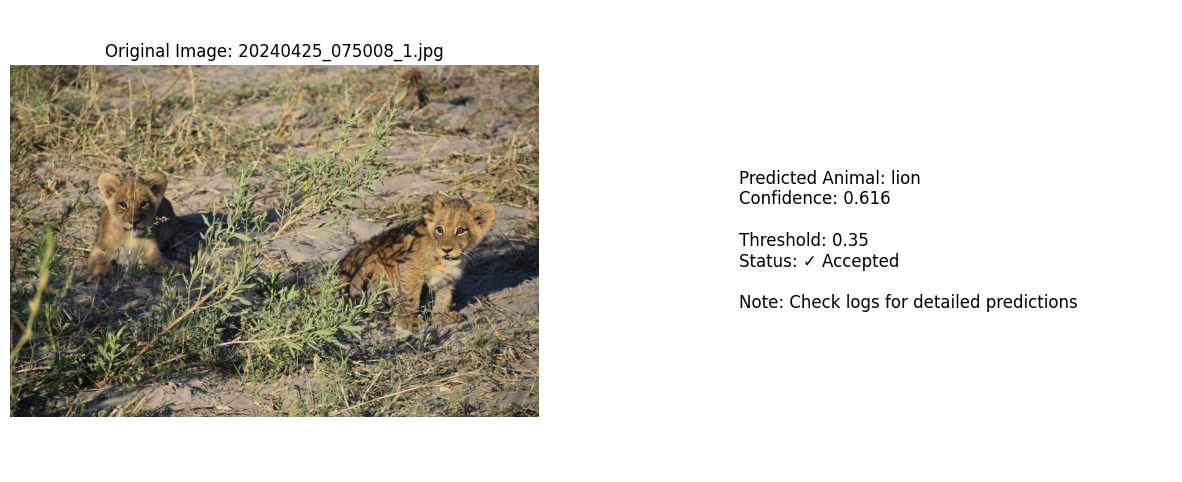

2024-10-27 13:41:54,261 - DEBUG - tag: Make (271) - type: string (2) Tag Location: 22 - Data Location: 172 - value: b'NIKON CORPORATION\x00'
2024-10-27 13:41:54,262 - DEBUG - tag: Model (272) - type: string (2) Tag Location: 34 - Data Location: 192 - value: b'NIKON D3500\x00'
2024-10-27 13:41:54,263 - DEBUG - tag: Orientation (274) - type: short (3) - value: b'\x01\x00'
2024-10-27 13:41:54,265 - DEBUG - tag: XResolution (282) - type: rational (5) Tag Location: 58 - Data Location: 204 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:54,266 - DEBUG - tag: YResolution (283) - type: rational (5) Tag Location: 70 - Data Location: 212 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:54,266 - DEBUG - tag: ResolutionUnit (296) - type: short (3) - value: b'\x02\x00'
2024-10-27 13:41:54,267 - DEBUG - tag: Software (305) - type: string (2) Tag Location: 94 - Data Location: 220 - value: b'Ver.1.00 \x00'
2024-10-27 13:41:54,268 - DEBUG - tag: DateTime (306) - type: string (2) Ta

Predicted: lion (Confidence: 0.616)

Image 10/10: 20241027_0001.jpg


2024-10-27 13:41:54,932 - DEBUG - tag: Make (271) - type: string (2) Tag Location: 22 - Data Location: 172 - value: b'NIKON CORPORATION\x00'
2024-10-27 13:41:54,933 - DEBUG - tag: Model (272) - type: string (2) Tag Location: 34 - Data Location: 192 - value: b'NIKON D3500\x00'
2024-10-27 13:41:54,934 - DEBUG - tag: Orientation (274) - type: short (3) - value: b'\x01\x00'
2024-10-27 13:41:54,934 - DEBUG - tag: XResolution (282) - type: rational (5) Tag Location: 58 - Data Location: 204 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:54,935 - DEBUG - tag: YResolution (283) - type: rational (5) Tag Location: 70 - Data Location: 212 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:54,936 - DEBUG - tag: ResolutionUnit (296) - type: short (3) - value: b'\x02\x00'
2024-10-27 13:41:54,936 - DEBUG - tag: Software (305) - type: string (2) Tag Location: 94 - Data Location: 220 - value: b'Ver.1.00 \x00'
2024-10-27 13:41:54,937 - DEBUG - tag: DateTime (306) - type: string (2) Ta

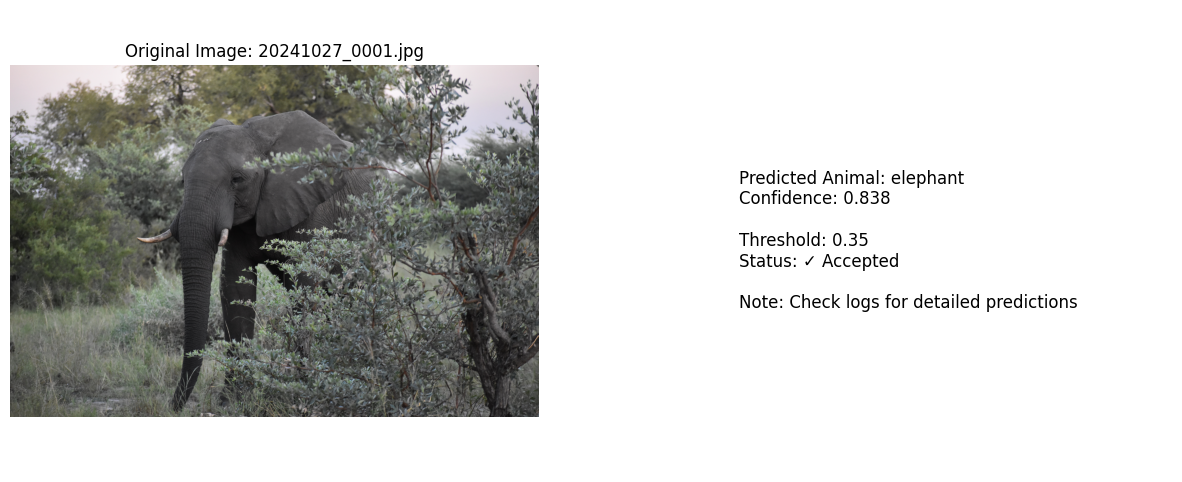

2024-10-27 13:41:59,810 - DEBUG - tag: Make (271) - type: string (2) Tag Location: 22 - Data Location: 172 - value: b'NIKON CORPORATION\x00'
2024-10-27 13:41:59,812 - DEBUG - tag: Model (272) - type: string (2) Tag Location: 34 - Data Location: 192 - value: b'NIKON D3500\x00'
2024-10-27 13:41:59,814 - DEBUG - tag: Orientation (274) - type: short (3) - value: b'\x01\x00'
2024-10-27 13:41:59,815 - DEBUG - tag: XResolution (282) - type: rational (5) Tag Location: 58 - Data Location: 204 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:59,815 - DEBUG - tag: YResolution (283) - type: rational (5) Tag Location: 70 - Data Location: 212 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:41:59,816 - DEBUG - tag: ResolutionUnit (296) - type: short (3) - value: b'\x02\x00'
2024-10-27 13:41:59,817 - DEBUG - tag: Software (305) - type: string (2) Tag Location: 94 - Data Location: 220 - value: b'Ver.1.00 \x00'
2024-10-27 13:41:59,817 - DEBUG - tag: DateTime (306) - type: string (2) Ta

Predicted: elephant (Confidence: 0.838)

Summary:
Total images: 10
Accepted predictions: 7
Rejected predictions: 3

Testing 10 images:

Image 1/10: 20240418_114116.jpg


2024-10-27 13:42:00,509 - DEBUG - tag: Make (271) - type: string (2) Tag Location: 22 - Data Location: 172 - value: b'NIKON CORPORATION\x00'
2024-10-27 13:42:00,510 - DEBUG - tag: Model (272) - type: string (2) Tag Location: 34 - Data Location: 192 - value: b'NIKON D3500\x00'
2024-10-27 13:42:00,510 - DEBUG - tag: Orientation (274) - type: short (3) - value: b'\x01\x00'
2024-10-27 13:42:00,511 - DEBUG - tag: XResolution (282) - type: rational (5) Tag Location: 58 - Data Location: 204 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:42:00,511 - DEBUG - tag: YResolution (283) - type: rational (5) Tag Location: 70 - Data Location: 212 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:42:00,512 - DEBUG - tag: ResolutionUnit (296) - type: short (3) - value: b'\x02\x00'
2024-10-27 13:42:00,513 - DEBUG - tag: Software (305) - type: string (2) Tag Location: 94 - Data Location: 220 - value: b'Ver.1.00 \x00'
2024-10-27 13:42:00,513 - DEBUG - tag: DateTime (306) - type: string (2) Ta

Predicted: bird (Confidence: 0.466)

Image 2/10: 20240418_130025_5.jpg


2024-10-27 13:42:04,120 - DEBUG - tag: Make (271) - type: string (2) Tag Location: 22 - Data Location: 172 - value: b'NIKON CORPORATION\x00'
2024-10-27 13:42:04,121 - DEBUG - tag: Model (272) - type: string (2) Tag Location: 34 - Data Location: 192 - value: b'NIKON D3500\x00'
2024-10-27 13:42:04,121 - DEBUG - tag: Orientation (274) - type: short (3) - value: b'\x01\x00'
2024-10-27 13:42:04,122 - DEBUG - tag: XResolution (282) - type: rational (5) Tag Location: 58 - Data Location: 204 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:42:04,123 - DEBUG - tag: YResolution (283) - type: rational (5) Tag Location: 70 - Data Location: 212 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:42:04,125 - DEBUG - tag: ResolutionUnit (296) - type: short (3) - value: b'\x02\x00'
2024-10-27 13:42:04,126 - DEBUG - tag: Software (305) - type: string (2) Tag Location: 94 - Data Location: 220 - value: b'Ver.1.00 \x00'
2024-10-27 13:42:04,126 - DEBUG - tag: DateTime (306) - type: string (2) Ta

Predicted: lion (Confidence: 0.014)

Image 3/10: 20240418_133453_2.jpg


2024-10-27 13:42:08,810 - DEBUG - tag: Make (271) - type: string (2) Tag Location: 22 - Data Location: 172 - value: b'NIKON CORPORATION\x00'
2024-10-27 13:42:08,812 - DEBUG - tag: Model (272) - type: string (2) Tag Location: 34 - Data Location: 192 - value: b'NIKON D3500\x00'
2024-10-27 13:42:08,814 - DEBUG - tag: Orientation (274) - type: short (3) - value: b'\x01\x00'
2024-10-27 13:42:08,814 - DEBUG - tag: XResolution (282) - type: rational (5) Tag Location: 58 - Data Location: 204 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:42:08,817 - DEBUG - tag: YResolution (283) - type: rational (5) Tag Location: 70 - Data Location: 212 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:42:08,818 - DEBUG - tag: ResolutionUnit (296) - type: short (3) - value: b'\x02\x00'
2024-10-27 13:42:08,819 - DEBUG - tag: Software (305) - type: string (2) Tag Location: 94 - Data Location: 220 - value: b'Ver.1.00 \x00'
2024-10-27 13:42:08,820 - DEBUG - tag: DateTime (306) - type: string (2) Ta

Predicted: bird (Confidence: 0.024)

Image 4/10: 20240419_173225.jpg


2024-10-27 13:42:13,065 - DEBUG - tag: Make (271) - type: string (2) Tag Location: 22 - Data Location: 172 - value: b'NIKON CORPORATION\x00'
2024-10-27 13:42:13,066 - DEBUG - tag: Model (272) - type: string (2) Tag Location: 34 - Data Location: 192 - value: b'NIKON D3500\x00'
2024-10-27 13:42:13,067 - DEBUG - tag: Orientation (274) - type: short (3) - value: b'\x01\x00'
2024-10-27 13:42:13,068 - DEBUG - tag: XResolution (282) - type: rational (5) Tag Location: 58 - Data Location: 204 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:42:13,069 - DEBUG - tag: YResolution (283) - type: rational (5) Tag Location: 70 - Data Location: 212 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:42:13,071 - DEBUG - tag: ResolutionUnit (296) - type: short (3) - value: b'\x02\x00'
2024-10-27 13:42:13,073 - DEBUG - tag: Software (305) - type: string (2) Tag Location: 94 - Data Location: 220 - value: b'Ver.1.00 \x00'
2024-10-27 13:42:13,073 - DEBUG - tag: DateTime (306) - type: string (2) Ta

Predicted: zebra (Confidence: 0.842)

Image 5/10: 20240420_072513.jpg


2024-10-27 13:42:17,631 - DEBUG - tag: Make (271) - type: string (2) Tag Location: 22 - Data Location: 172 - value: b'NIKON CORPORATION\x00'
2024-10-27 13:42:17,633 - DEBUG - tag: Model (272) - type: string (2) Tag Location: 34 - Data Location: 192 - value: b'NIKON D3500\x00'
2024-10-27 13:42:17,634 - DEBUG - tag: Orientation (274) - type: short (3) - value: b'\x06\x00'
2024-10-27 13:42:17,635 - DEBUG - tag: XResolution (282) - type: rational (5) Tag Location: 58 - Data Location: 204 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:42:17,635 - DEBUG - tag: YResolution (283) - type: rational (5) Tag Location: 70 - Data Location: 212 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:42:17,636 - DEBUG - tag: ResolutionUnit (296) - type: short (3) - value: b'\x02\x00'
2024-10-27 13:42:17,636 - DEBUG - tag: Software (305) - type: string (2) Tag Location: 94 - Data Location: 220 - value: b'Ver.1.00 \x00'
2024-10-27 13:42:17,637 - DEBUG - tag: DateTime (306) - type: string (2) Ta

Predicted: leopard (Confidence: 0.776)

Image 6/10: 20240420_082333.jpg


2024-10-27 13:42:21,980 - DEBUG - tag: Make (271) - type: string (2) Tag Location: 22 - Data Location: 172 - value: b'NIKON CORPORATION\x00'
2024-10-27 13:42:21,980 - DEBUG - tag: Model (272) - type: string (2) Tag Location: 34 - Data Location: 192 - value: b'NIKON D3500\x00'
2024-10-27 13:42:21,982 - DEBUG - tag: Orientation (274) - type: short (3) - value: b'\x06\x00'
2024-10-27 13:42:21,983 - DEBUG - tag: XResolution (282) - type: rational (5) Tag Location: 58 - Data Location: 204 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:42:21,984 - DEBUG - tag: YResolution (283) - type: rational (5) Tag Location: 70 - Data Location: 212 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:42:21,985 - DEBUG - tag: ResolutionUnit (296) - type: short (3) - value: b'\x02\x00'
2024-10-27 13:42:21,986 - DEBUG - tag: Software (305) - type: string (2) Tag Location: 94 - Data Location: 220 - value: b'Ver.1.00 \x00'
2024-10-27 13:42:21,986 - DEBUG - tag: DateTime (306) - type: string (2) Ta

Predicted: leopard (Confidence: 0.034)

Image 7/10: 20240420_095729.jpg


2024-10-27 13:42:25,809 - DEBUG - tag: Make (271) - type: string (2) Tag Location: 22 - Data Location: 172 - value: b'NIKON CORPORATION\x00'
2024-10-27 13:42:25,810 - DEBUG - tag: Model (272) - type: string (2) Tag Location: 34 - Data Location: 192 - value: b'NIKON D3500\x00'
2024-10-27 13:42:25,811 - DEBUG - tag: Orientation (274) - type: short (3) - value: b'\x01\x00'
2024-10-27 13:42:25,812 - DEBUG - tag: XResolution (282) - type: rational (5) Tag Location: 58 - Data Location: 204 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:42:25,812 - DEBUG - tag: YResolution (283) - type: rational (5) Tag Location: 70 - Data Location: 212 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:42:25,814 - DEBUG - tag: ResolutionUnit (296) - type: short (3) - value: b'\x02\x00'
2024-10-27 13:42:25,815 - DEBUG - tag: Software (305) - type: string (2) Tag Location: 94 - Data Location: 220 - value: b'Ver.1.00 \x00'
2024-10-27 13:42:25,815 - DEBUG - tag: DateTime (306) - type: string (2) Ta

Predicted: hyena (Confidence: 0.724)

Image 8/10: 20240425_073230.jpg


2024-10-27 13:42:29,929 - DEBUG - tag: Make (271) - type: string (2) Tag Location: 22 - Data Location: 172 - value: b'NIKON CORPORATION\x00'
2024-10-27 13:42:29,930 - DEBUG - tag: Model (272) - type: string (2) Tag Location: 34 - Data Location: 192 - value: b'NIKON D3500\x00'
2024-10-27 13:42:29,930 - DEBUG - tag: Orientation (274) - type: short (3) - value: b'\x01\x00'
2024-10-27 13:42:29,931 - DEBUG - tag: XResolution (282) - type: rational (5) Tag Location: 58 - Data Location: 204 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:42:29,932 - DEBUG - tag: YResolution (283) - type: rational (5) Tag Location: 70 - Data Location: 212 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:42:29,933 - DEBUG - tag: ResolutionUnit (296) - type: short (3) - value: b'\x02\x00'
2024-10-27 13:42:29,934 - DEBUG - tag: Software (305) - type: string (2) Tag Location: 94 - Data Location: 220 - value: b'Ver.1.00 \x00'
2024-10-27 13:42:29,934 - DEBUG - tag: DateTime (306) - type: string (2) Ta

Predicted: lion (Confidence: 0.890)

Image 9/10: 20240425_075008_1.jpg


2024-10-27 13:42:34,202 - DEBUG - tag: Make (271) - type: string (2) Tag Location: 22 - Data Location: 172 - value: b'NIKON CORPORATION\x00'
2024-10-27 13:42:34,203 - DEBUG - tag: Model (272) - type: string (2) Tag Location: 34 - Data Location: 192 - value: b'NIKON D3500\x00'
2024-10-27 13:42:34,205 - DEBUG - tag: Orientation (274) - type: short (3) - value: b'\x01\x00'
2024-10-27 13:42:34,206 - DEBUG - tag: XResolution (282) - type: rational (5) Tag Location: 58 - Data Location: 204 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:42:34,207 - DEBUG - tag: YResolution (283) - type: rational (5) Tag Location: 70 - Data Location: 212 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:42:34,207 - DEBUG - tag: ResolutionUnit (296) - type: short (3) - value: b'\x02\x00'
2024-10-27 13:42:34,208 - DEBUG - tag: Software (305) - type: string (2) Tag Location: 94 - Data Location: 220 - value: b'Ver.1.00 \x00'
2024-10-27 13:42:34,208 - DEBUG - tag: DateTime (306) - type: string (2) Ta

Predicted: lion (Confidence: 0.616)

Image 10/10: 20241027_0001.jpg


2024-10-27 13:42:38,270 - DEBUG - tag: Make (271) - type: string (2) Tag Location: 22 - Data Location: 172 - value: b'NIKON CORPORATION\x00'
2024-10-27 13:42:38,271 - DEBUG - tag: Model (272) - type: string (2) Tag Location: 34 - Data Location: 192 - value: b'NIKON D3500\x00'
2024-10-27 13:42:38,272 - DEBUG - tag: Orientation (274) - type: short (3) - value: b'\x01\x00'
2024-10-27 13:42:38,272 - DEBUG - tag: XResolution (282) - type: rational (5) Tag Location: 58 - Data Location: 204 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:42:38,273 - DEBUG - tag: YResolution (283) - type: rational (5) Tag Location: 70 - Data Location: 212 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:42:38,273 - DEBUG - tag: ResolutionUnit (296) - type: short (3) - value: b'\x02\x00'
2024-10-27 13:42:38,274 - DEBUG - tag: Software (305) - type: string (2) Tag Location: 94 - Data Location: 220 - value: b'Ver.1.00 \x00'
2024-10-27 13:42:38,275 - DEBUG - tag: DateTime (306) - type: string (2) Ta

Predicted: elephant (Confidence: 0.838)

Summary:
Total images: 10
Accepted predictions: 7
Rejected predictions: 3


2024-10-27 13:42:42,021 - DEBUG - tag: Make (271) - type: string (2) Tag Location: 22 - Data Location: 172 - value: b'NIKON CORPORATION\x00'
2024-10-27 13:42:42,022 - DEBUG - tag: Model (272) - type: string (2) Tag Location: 34 - Data Location: 192 - value: b'NIKON D3500\x00'
2024-10-27 13:42:42,023 - DEBUG - tag: Orientation (274) - type: short (3) - value: b'\x01\x00'
2024-10-27 13:42:42,024 - DEBUG - tag: XResolution (282) - type: rational (5) Tag Location: 58 - Data Location: 204 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:42:42,025 - DEBUG - tag: YResolution (283) - type: rational (5) Tag Location: 70 - Data Location: 212 - value: b',\x01\x00\x00\x01\x00\x00\x00'
2024-10-27 13:42:42,026 - DEBUG - tag: ResolutionUnit (296) - type: short (3) - value: b'\x02\x00'
2024-10-27 13:42:42,026 - DEBUG - tag: Software (305) - type: string (2) Tag Location: 94 - Data Location: 220 - value: b'Ver.1.00 \x00'
2024-10-27 13:42:42,026 - DEBUG - tag: DateTime (306) - type: string (2) Ta

In [24]:
class SafariImageTester:
    def __init__(self, test_dir):
        """Initialize the tester with test directory"""
        self.test_dir = Path(test_dir)
        self.processor = SafariImageProcessor(self.test_dir)
        
    def test_single(self, image_name=None):
        """Test a single image, either specified or first found"""
        if image_name:
            image_path = self.test_dir / image_name
        else:
            # Get first image
            images = list(self.test_dir.glob("*.[jJ][pP][gG]"))
            if not images:
                print("No images found in test directory")
                return
            image_path = images[0]
            
        print(f"\nTesting image: {image_path.name}")
        
        # Enable debug logging temporarily
        # logging.getLogger().setLevel(logging.DEBUG)
        
        # Show preview with predictions
        animal, confidence = self.processor.preview_image_prediction(image_path)
        
        # Reset logging level
        # logging.getLogger().setLevel(logging.INFO)
        
        print("\nResults:")
        print(f"Animal: {animal}")
        print(f"Confidence: {confidence:.3f}")
        print(f"Status: {'✓ Accepted' if confidence > 0.35 else '✗ Rejected'}")
        
        return animal, confidence
    
    def test_all(self, preview=True):
        """Test all images in directory"""
        images = list(self.test_dir.glob("*.[jJ][pP][gG]"))
        if not images:
            print("No images found in test directory")
            return []
        
        results = []
        print(f"\nTesting {len(images)} images:")
        
        for i, img_path in enumerate(images, 1):
            print(f"\nImage {i}/{len(images)}: {img_path.name}")
            
            if preview:
                animal, confidence = self.processor.preview_image_prediction(img_path)
            else:
                animal, confidence = self.processor._predict_animal(img_path)
            
            results.append({
                'image': img_path.name,
                'animal': animal,
                'confidence': confidence,
                'accepted': confidence > 0.35
            })
            
            print(f"Predicted: {animal} (Confidence: {confidence:.3f})")
        
        # Print summary
        print("\nSummary:")
        accepted = sum(1 for r in results if r['accepted'])
        print(f"Total images: {len(results)}")
        print(f"Accepted predictions: {accepted}")
        print(f"Rejected predictions: {len(results) - accepted}")
        
        return results
    
    def process_all(self):
        """Process all images (rename and tag)"""
        return self.processor.process_images()

logging.disable(logging.CRITICAL)  # Disables all logging
# Usage:
tester = SafariImageTester("test_images")

# # Test single image
# tester.test_single()  # Tests first image found
# or
tester.test_single("20241027_0001.jpg")  # Test specific image

# # Test all images with previews
# results = tester.test_all(preview=True)

# # Test all images without previews (faster)
# results = tester.test_all(preview=False)

# # Process all images (rename and tag)
processed_results = tester.process_all()

In [12]:
# Process the first image completely
if test_images:
    result = processor.process_single_image(test_images[0])
    print("\nProcessing Results:")
    for key, value in result.items():
        print(f"{key}: {value}")

2024-10-27 13:21:47,696 - INFO - Created backup of 20240418_114116.jpg



Processing Results:
original_name: 20240418_114116.jpg
success: False
new_name: None
animal: None
confidence: 0.0
error: Low confidence prediction


In [14]:
# Process all images in the test directory
def process_and_display_results():
    results = processor.process_images()
    
    print(f"\nProcessed {len(results)} images:")
    for result in results:
        print("\n---")
        for key, value in result.items():
            print(f"{key}: {value}")

# Uncomment the following line when ready to process all images
process_and_display_results()

2024-10-27 13:22:49,636 - INFO - Created backup of 20240418_114116.jpg
2024-10-27 13:22:51,666 - INFO - Created backup of 20240418_130025_5.jpg
2024-10-27 13:22:53,563 - INFO - Created backup of 20240418_133453_2.jpg
2024-10-27 13:22:55,609 - INFO - Created backup of 20240419_173225.jpg
2024-10-27 13:22:57,652 - INFO - Created backup of 20240420_072513.jpg
2024-10-27 13:22:59,833 - INFO - Created backup of 20240420_082333.jpg
2024-10-27 13:23:01,940 - INFO - Created backup of 20240420_095729.jpg
2024-10-27 13:23:03,655 - INFO - Created backup of 20240425_073230.jpg
2024-10-27 13:23:05,722 - INFO - Created backup of 20240425_075008_1.jpg
2024-10-27 13:23:08,894 - INFO - Created backup of elephant_20241027_0001.jpg
2024-10-27 13:23:10,682 - WARNING - Failed to add metadata to test_images\elephant_20241027_0001.jpg: module 'piexif' has no attribute 'helper'



Processed 10 images:

---
original_name: 20240418_114116.jpg
success: False
new_name: None
animal: None
confidence: 0.0
error: Low confidence prediction

---
original_name: 20240418_130025_5.jpg
success: False
new_name: None
animal: None
confidence: 0.0
error: Low confidence prediction

---
original_name: 20240418_133453_2.jpg
success: False
new_name: None
animal: None
confidence: 0.0
error: Low confidence prediction

---
original_name: 20240419_173225.jpg
success: False
new_name: None
animal: zebra
confidence: 0.43036457896232605
error: Low confidence prediction

---
original_name: 20240420_072513.jpg
success: False
new_name: None
animal: leopard
confidence: 0.32531341910362244
error: Low confidence prediction

---
original_name: 20240420_082333.jpg
success: False
new_name: None
animal: None
confidence: 0.0
error: Low confidence prediction

---
original_name: 20240420_095729.jpg
success: False
new_name: None
animal: hyena
confidence: 0.13899196684360504
error: Low confidence predicti